<a href="https://colab.research.google.com/github/k-vinamr/rera_construction_pred/blob/main/1_nov_9_floor_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [2]:
data = pd.read_excel('9_floor_data.xlsx')

In [3]:
data.head()


,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,Cleaning & survey,...,9th floor Columns casting,9th Floor slab casting,Brick work of 7th to 9th Floor,"Electrical concealed, PVC Fitting, plastering at 6th-9th floor",Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,other work
0,Neumec Venture,Residential/Group Housing,2017-07-29,2019-03-31,340.86,370.00,9,MAHARASHTRA,610,5.254091,...,6.830319,11.559001,18.389320,27.321275,39.405685,47.286822,47.286822,39.405685,47.286822,15.762274
1,NASIM NIYAZ KHAN,Residential/Group Housing,2018-05-25,2019-12-31,364.21,178.00,9,MAHARASHTRA,585,5.038760,...,6.550388,11.085271,17.635659,26.201550,37.790698,45.348837,45.348837,37.790698,45.348837,15.116279
2,SUNIL DINKAR SHINDE,Residential/Group Housing,2021-09-09,2022-06-30,432.14,432.40,9,MAHARASHTRA,294,2.532300,...,3.291990,5.571059,8.863049,13.167959,18.992248,22.790698,22.790698,18.992248,22.790698,7.596899
3,Rajnikant Last Name Sanchala,Residential/Group Housing,2022-04-20,2028-12-31,485.67,490.40,9,MAHARASHTRA,2447,21.076658,...,27.399655,46.368648,73.768303,109.598622,158.074935,189.689922,189.689922,158.074935,189.689922,63.229974
4,MS AMANN RAJ HOUSING AND DEVELOPMENT CORPORATION,Residential/Group Housing,2017-08-14,2020-07-31,519.98,1247.85,9,MAHARASHTRA,1082,9.319552,...,12.115418,20.503015,32.618432,48.461671,69.896641,83.875969,83.875969,69.896641,83.875969,27.958656


In [4]:
# Converting date columns to datetime objects
data['actual_commencement_date'] = pd.to_datetime(data['actual_commencement_date'], format='%d-%m-%Y', errors='coerce')
data['estimated_finish_date'] = pd.to_datetime(data['estimated_finish_date'], format='%d-%m-%Y', errors='coerce')


In [5]:
current_date = datetime.now()

In [6]:
data['duration_since_commencement'] = (current_date - data['actual_commencement_date']).dt.days
data['remaining_duration'] = (data['estimated_finish_date'] - current_date).dt.days
data['progress_ratio'] = data['duration_since_commencement'] / data['total_days']

In [7]:
# Define a function to determine the project status
def determine_status(row):
    if current_date > row['estimated_finish_date']:
        return 'completed'
    elif current_date >= row['actual_commencement_date']:
        return 'running'
    else:
        return 'upcoming'

# Apply the function to create the 'Status' column
data['current_stage'] = data.apply(determine_status, axis=1)

# Print the DataFrame with the 'Status' column
data


,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,Cleaning & survey,...,Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,other work,duration_since_commencement,remaining_duration,progress_ratio,current_stage
0,Neumec Venture,Residential/Group Housing,2017-07-29,2019-03-31,340.86,370.00,9,MAHARASHTRA,610,5.254091,...,39.405685,47.286822,47.286822,39.405685,47.286822,15.762274,2286,-1677,3.747541,completed
1,NASIM NIYAZ KHAN,Residential/Group Housing,2018-05-25,2019-12-31,364.21,178.00,9,MAHARASHTRA,585,5.038760,...,37.790698,45.348837,45.348837,37.790698,45.348837,15.116279,1986,-1402,3.394872,completed
2,SUNIL DINKAR SHINDE,Residential/Group Housing,2021-09-09,2022-06-30,432.14,432.40,9,MAHARASHTRA,294,2.532300,...,18.992248,22.790698,22.790698,18.992248,22.790698,7.596899,783,-490,2.663265,completed
3,Rajnikant Last Name Sanchala,Residential/Group Housing,2022-04-20,2028-12-31,485.67,490.40,9,MAHARASHTRA,2447,21.076658,...,158.074935,189.689922,189.689922,158.074935,189.689922,63.229974,560,1886,0.228852,running
4,MS AMANN RAJ HOUSING AND DEVELOPMENT CORPORATION,Residential/Group Housing,2017-08-14,2020-07-31,519.98,1247.85,9,MAHARASHTRA,1082,9.319552,...,69.896641,83.875969,83.875969,69.896641,83.875969,27.958656,2270,-1189,2.097967,completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,Unnati Infratech,Residential/Group Housing,2019-09-01,2023-02-28,49937.22,10651.84,9,Rajasthan,1276,10.990525,...,82.428941,98.914729,98.914729,82.428941,98.914729,32.971576,1522,-247,1.192790,completed
448,Archi Civil Construction Private Limited,Residential/Group Housing,2020-02-20,2026-12-29,51263.17,9121.28,9,Rajasthan,2504,21.567614,...,161.757106,194.108527,194.108527,161.757106,194.108527,64.702842,1350,1153,0.539137,running
449,Archi Buildmart Private Limited,Residential/Group Housing,2020-03-31,2025-12-23,55515.44,16644.33,9,Rajasthan,2093,18.027562,...,135.206718,162.248062,162.248062,135.206718,162.248062,54.082687,1310,782,0.625896,running
450,Veena Developers,Residential/Group Housing,2021-08-09,2023-12-30,63358.00,27422.04,9,MAHARASHTRA,873,7.519380,...,56.395349,67.674419,67.674419,56.395349,67.674419,22.558140,814,58,0.932417,running


In [8]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
data['area_bin'] = pd.cut(data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    data_min = grouped[feature].min()
    data_max = grouped[feature].max()
    data_mean = grouped[feature].mean()
    data_count = grouped[feature].count()
    result = pd.concat([data_min, data_max, data_mean, data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         294.0  2447.0   984.000000      4
(500, 1000]      112.0  1534.0   772.323529     34
(1000, 1500]     112.0  1702.0   831.057971     69
(1500, 2000]     112.0  1784.0   882.488372     43
(2000, 2500]     134.0  2151.0   921.477273     44
...                ...     ...          ...    ...
(62000, 62500]     NaN     NaN          NaN      0
(62500, 63000]     NaN     NaN          NaN      0
(63000, 63500]   873.0   873.0   873.000000      1
(63500, 64000]     NaN     NaN          NaN      0
(64000, 64500]  1722.0  1722.0  1722.000000      1

[129 rows x 4 columns]




In [12]:
# Filter the DataFrame based on the condition
filtered_data = data[data['total_built_up_area_saleable_area'] < 50000]

In [13]:
# Assuming you have your data in a DataFrame named df
# If it's not, you can read your data from a CSV or any other source

# Define the bin edges
bin_width = 500
max_value = int(filtered_data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
filtered_data['area_bin'] = pd.cut(filtered_data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = filtered_data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    filtered_data_min = grouped[feature].min()
    filtered_data_max = grouped[feature].max()
    filtered_data_mean = grouped[feature].mean()
    filtered_data_count = grouped[feature].count()
    result = pd.concat([filtered_data_min, filtered_data_max, filtered_data_mean, filtered_data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         294.0  2447.0   984.000000      4
(500, 1000]      112.0  1534.0   772.323529     34
(1000, 1500]     112.0  1702.0   831.057971     69
(1500, 2000]     112.0  1784.0   882.488372     43
(2000, 2500]     134.0  2151.0   921.477273     44
...                ...     ...          ...    ...
(47500, 48000]     NaN     NaN          NaN      0
(48000, 48500]  2164.0  2253.0  2208.500000      2
(48500, 49000]     NaN     NaN          NaN      0
(49000, 49500]     NaN     NaN          NaN      0
(49500, 50000]  1276.0  1276.0  1276.000000      1

[100 rows x 4 columns]




<ipython-input-13-3ac3ef85beec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['area_bin'] = pd.cut(filtered_data['total_built_up_area_saleable_area'], bin_edges)


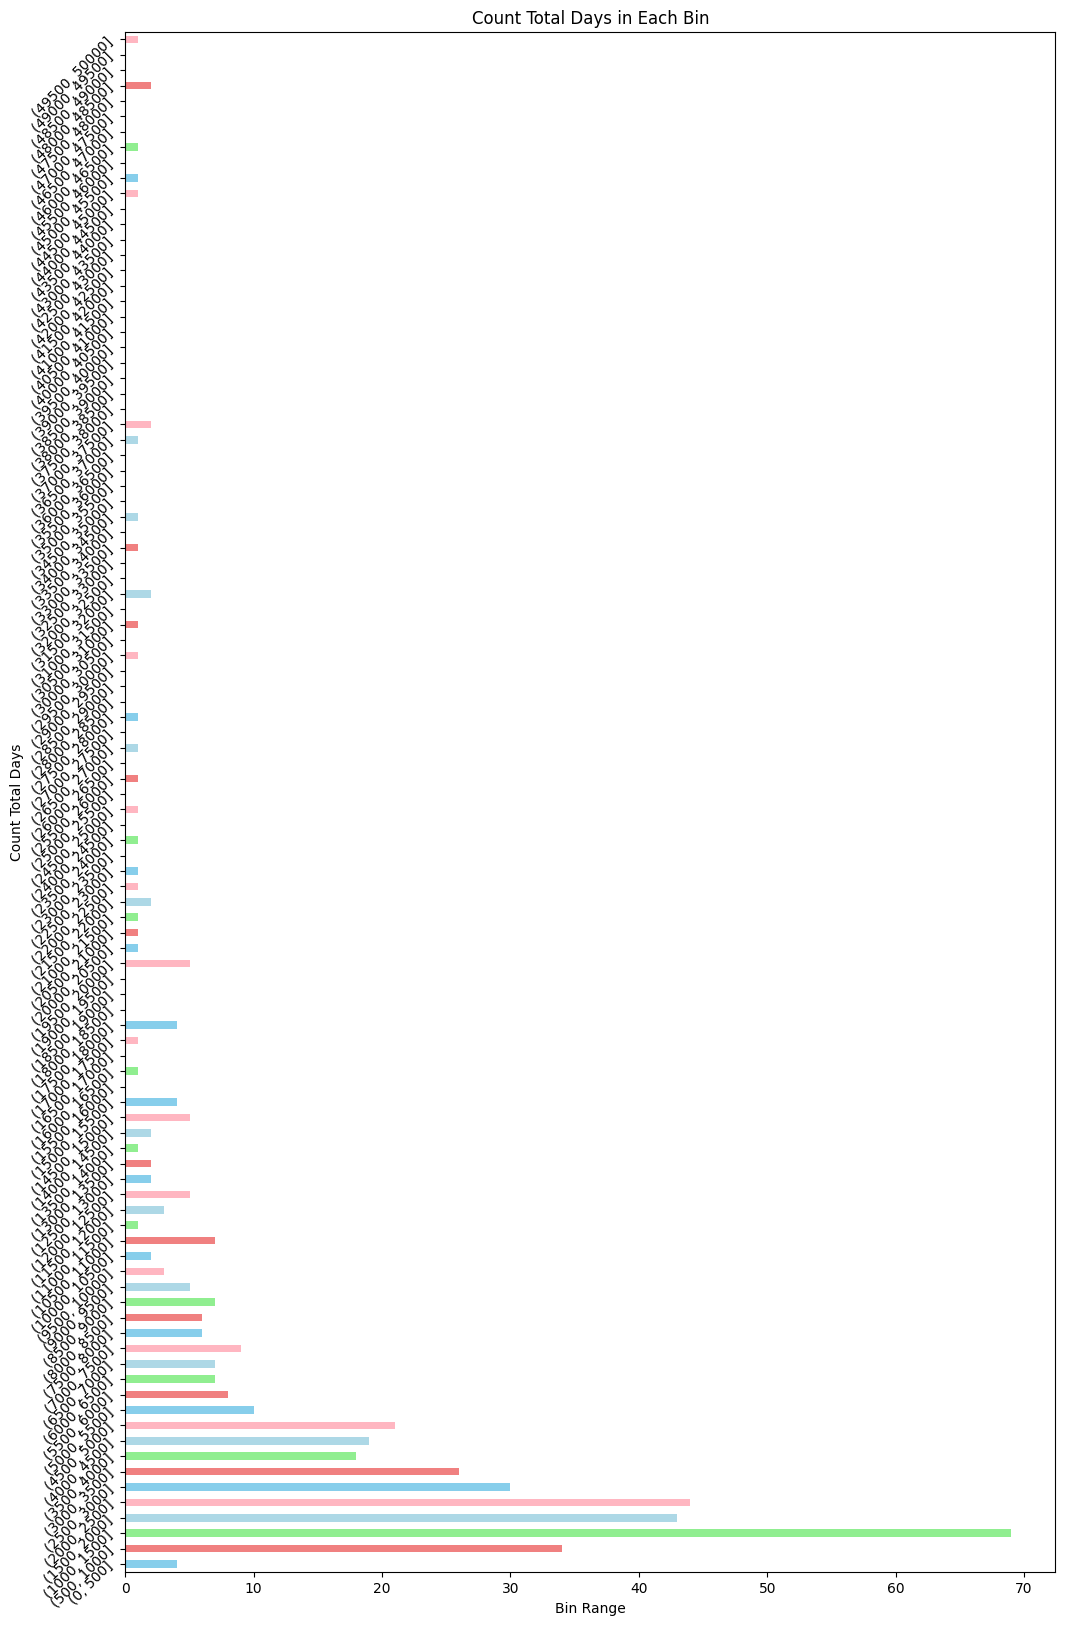

In [14]:
# Create a bar chart for the mean values
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightpink']
plt.figure(figsize=(12, 20))
filtered_data_count.plot(kind='barh', color=colors)
plt.xlabel('Bin Range')
plt.ylabel('Count Total Days')
plt.title('Count Total Days in Each Bin')
plt.yticks(range(len(filtered_data_count)), filtered_data_count.index, rotation=45)
plt.show()


In [15]:
import pandas as pd
import random
from datetime import timedelta

# Assuming you have your filtered data in a DataFrame named filtered_df
# Ensure you have loaded the necessary libraries and data

# Define the number of data points you want to generate
desired_data_points = 10000  # Change this number as needed

# Create an empty DataFrame to store the augmented data
augmented_data = pd.DataFrame(columns=filtered_data.columns)

# Copy the original data to the augmented DataFrame
augmented_data = augmented_data.append(filtered_data, ignore_index=True)

# Define the range for small changes (you can adjust this)
date_change_range = 7  # Number of days for date changes
area_change_range = 10  # Range for changing area

# Generate additional data points
while len(augmented_data) < desired_data_points:
    # Randomly select an existing row to modify
    index_to_modify = random.randint(0, len(filtered_data) - 1)
    row_to_modify = augmented_data.iloc[index_to_modify].copy()

    # Make small changes to the selected row
    row_to_modify['actual_commencement_date'] += timedelta(days=random.randint(-date_change_range, date_change_range))
    row_to_modify['estimated_finish_date'] += timedelta(days=random.randint(-date_change_range, date_change_range))
    row_to_modify['total_built_up_area_saleable_area'] += random.uniform(-area_change_range, area_change_range)
    row_to_modify['total_area_of_project'] += random.uniform(-area_change_range, area_change_range)

    # Add the modified row to the augmented DataFrame
    augmented_data = augmented_data.append(row_to_modify, ignore_index=True)

    # You may want to truncate the DataFrame to the desired number of data points
    augmented_data = augmented_data[:desired_data_points]

    # Now, augmented_data contains the augmented data with the specified changes

Streaming output truncated to the last 5000 lines.
<ipython-input-15-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-15-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-15-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_modify, ignore_index=True)
<ipython-input-15-b5558fb047dd>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data = augmented_data.append(row_to_

In [16]:
# Define the bin edges
bin_width = 500
max_value = int(augmented_data['total_built_up_area_saleable_area'].max())
bin_edges = list(range(0, max_value + bin_width, bin_width))  # Creates bins of size 500

# Create a new column to store the bin labels
augmented_data['area_bin'] = pd.cut(augmented_data['total_built_up_area_saleable_area'], bin_edges)

# Group the data by the 'area_bin' column
grouped = augmented_data.groupby('area_bin')

# Define the features you want to analyze
features = ['total_days']  # Add more features as needed

# Iterate over the groups and calculate min and max for each feature
for feature in features:
    augmented_data_min = grouped[feature].min()
    augmented_data_max = grouped[feature].max()
    augmented_data_mean = grouped[feature].mean()
    augmented_data_count = grouped[feature].count()
    result = pd.concat([augmented_data_min, augmented_data_max, augmented_data_mean, augmented_data_count], axis=1)
    result.columns = ['Min', 'Max', 'Mean', 'Count']
    print(f"Statistics for '{feature}':")
    print(result)
    print("\n")

Statistics for 'total_days':
                   Min     Max         Mean  Count
area_bin                                          
(0, 500]         294.0  2447.0  1039.728395     81
(500, 1000]      112.0  1534.0   799.027926    752
(1000, 1500]     112.0  1702.0   822.786479   1494
(1500, 2000]     112.0  1784.0   884.049383    972
(2000, 2500]     134.0  2151.0   921.683179    969
...                ...     ...          ...    ...
(47500, 48000]     NaN     NaN          NaN      0
(48000, 48500]  2164.0  2253.0  2221.355556     45
(48500, 49000]     NaN     NaN          NaN      0
(49000, 49500]     NaN     NaN          NaN      0
(49500, 50000]  1276.0  1276.0  1276.000000     27

[100 rows x 4 columns]




In [17]:
augmented_data.to_csv('augmented_9_floor.csv', index=False)